# Notebook 4: Understanding Policies

The **policy** is the heart of reinforcement learning - it's the agent's decision-making strategy. In this notebook, we'll explore different types of policies and understand what makes a good policy.

## What You'll Learn

1. What is a policy?
2. Random policies (baseline)
3. Linear policies (simple but effective)
4. Neural network policies (deep RL)
5. Comparing policy performance

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from src.environments import InvertedPendulumEnv
from src.policies import RandomPolicy, LinearPolicy, NeuralNetworkPolicy
from src.utils import evaluate_policy, collect_episode, plot_trajectory

## 1. What is a Policy?

A policy $\pi$ is a function that maps states to actions:

$$a = \pi(s)$$

### Types of Policies

**Deterministic**: Same state always gives same action
- $\pi(s) = a$

**Stochastic**: Returns a probability distribution over actions
- $\pi(a|s) = P(a|s)$

### What Makes a Good Policy?

A good policy for the inverted pendulum should:
1. Respond quickly to pole tilts
2. Use appropriate force magnitude
3. Consider both position and velocity
4. Keep the cart centered (not just balance)

## 2. Random Policy (Baseline)

The simplest policy - completely ignores the state and picks random actions.

This serves as a **baseline** - any learning algorithm should beat random!

In [2]:
# Create a random policy
random_policy = RandomPolicy(action_low=-10.0, action_high=10.0)

# See what it does
state = np.array([0, 0, 0.1, 0])  # Leaning right

print("Random Policy Actions:")
for i in range(5):
    action = random_policy.get_action(state)
    print(f"  Action {i+1}: {action:.2f} N")

print("\nNotice: Actions are random regardless of state!")

Random Policy Actions:
  Action 1: 7.87 N
  Action 2: -2.82 N
  Action 3: 8.82 N
  Action 4: -9.25 N
  Action 5: 6.63 N

Notice: Actions are random regardless of state!


In [3]:
# Evaluate the random policy
env = InvertedPendulumEnv()
result = evaluate_policy(env, random_policy, n_episodes=50, seed=42)

print("Random Policy Performance:")
print(f"  Mean reward: {result['mean_reward']:.1f} ± {result['std_reward']:.1f}")
print(f"  Mean episode length: {result['mean_length']:.1f} steps")
print(f"\n  (Max possible: {env.max_steps} steps)")

Random Policy Performance:
  Mean reward: 24.1 ± 11.2
  Mean episode length: 25.1 steps

  (Max possible: 500 steps)


## 3. Linear Policy

A linear policy computes the action as a weighted sum of state features:

$$a = w_1 x + w_2 \dot{x} + w_3 \theta + w_4 \dot{\theta} + b$$

The weights $(w_1, w_2, w_3, w_4, b)$ are the **parameters** we can learn!

### Why Linear?
- Easy to understand and interpret
- Fast to compute
- Few parameters (easy to optimize)
- Can be surprisingly effective!

In [4]:
# Create a linear policy with zero weights
linear_policy = LinearPolicy()

print("Linear Policy Parameters:")
print(f"  Weights: {linear_policy.weights}")
print(f"  Bias: {linear_policy.bias}")
print(f"  Total parameters: {linear_policy.get_num_params()}")

# Test with zero weights (will output zero)
state = np.array([0, 0, 0.1, 0])
action = linear_policy.get_action(state)
print(f"\nAction for state {state}: {action}")

Linear Policy Parameters:
  Weights: [0. 0. 0. 0.]
  Bias: 0.0
  Total parameters: 5

Action for state [0.  0.  0.1 0. ]: 0.0


In [5]:
# Set weights manually based on our intuition:
# - Positive theta (leaning right) -> positive force (push right)
# - Positive theta_dot (falling right) -> even more positive force

linear_policy.weights = np.array([0, 0, 10, 3])  # [x, x_dot, theta, theta_dot]
linear_policy.bias = 0

print("Manual weights: [x=0, x_dot=0, theta=10, theta_dot=3]")
print("\nThis means:")
print("  - Ignore cart position and velocity")
print("  - action = 10*theta + 3*theta_dot")

# Test on different states
test_states = [
    np.array([0, 0, 0.1, 0]),   # Leaning right
    np.array([0, 0, -0.1, 0]),  # Leaning left
    np.array([0, 0, 0.1, 0.5]), # Falling right fast
]

print("\nTest actions:")
for state in test_states:
    action = linear_policy.get_action(state)
    print(f"  θ={state[2]:.2f}, θ̇={state[3]:.2f} -> action={action:.2f}")

Manual weights: [x=0, x_dot=0, theta=10, theta_dot=3]

This means:
  - Ignore cart position and velocity
  - action = 10*theta + 3*theta_dot

Test actions:
  θ=0.10, θ̇=0.00 -> action=1.00
  θ=-0.10, θ̇=0.00 -> action=-1.00
  θ=0.10, θ̇=0.50 -> action=2.50


In [6]:
# Evaluate the manually-tuned linear policy
result = evaluate_policy(env, linear_policy, n_episodes=50, seed=42)

print("Linear Policy (manual weights) Performance:")
print(f"  Mean reward: {result['mean_reward']:.1f} ± {result['std_reward']:.1f}")
print(f"  Mean episode length: {result['mean_length']:.1f} steps")

Linear Policy (manual weights) Performance:
  Mean reward: 207.2 ± 71.2
  Mean episode length: 208.2 steps


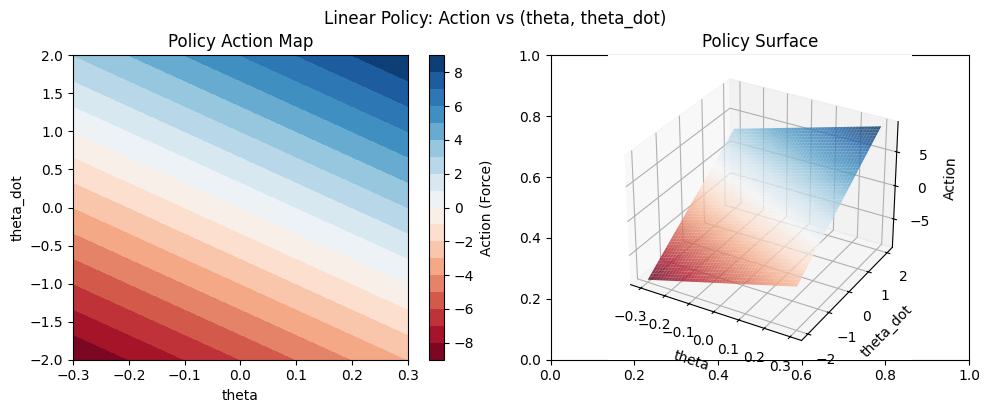

In [7]:
# Let's visualize what the linear policy does
from src.utils.visualization import plot_policy_surface

fig = plot_policy_surface(
    linear_policy,
    state_ranges={'theta': (-0.3, 0.3), 'theta_dot': (-2, 2)},
    fixed_states={'x': 0, 'x_dot': 0}
)
plt.suptitle('Linear Policy: Action vs (theta, theta_dot)', y=1.02)
plt.show()

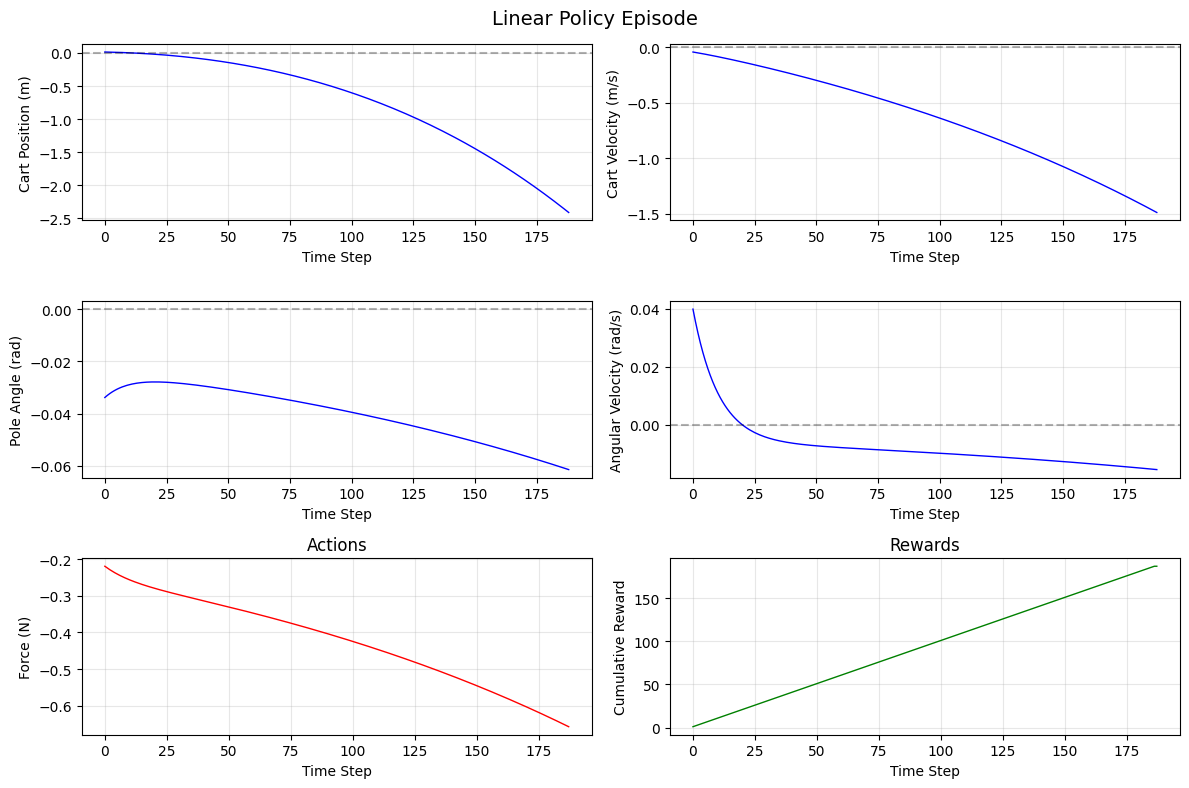

In [8]:
# Run and visualize an episode
states, actions, rewards, info = collect_episode(env, linear_policy)
history = {
    'states': np.array(states),
    'actions': np.array(actions),
    'rewards': np.array(rewards)
}

fig = plot_trajectory(history, title="Linear Policy Episode")
plt.show()

## 4. Neural Network Policy

A neural network can represent much more complex functions:

$$a = \text{NN}(s; \theta)$$

Where $\theta$ are the network weights and biases.

### Architecture
- Input layer: 4 neurons (state)
- Hidden layers: Configurable (e.g., 64 -> 64)
- Output layer: 1 neuron (action)
- Activation: ReLU for hidden, Tanh for output

In [9]:
# Create a neural network policy
nn_policy = NeuralNetworkPolicy(hidden_sizes=[64, 64])

print("Neural Network Policy:")
print(nn_policy.get_network_summary())

Neural Network Policy:
Neural Network Policy Architecture:
  0: Linear(4 -> 64) [320 params]
  1: ReLU
  2: Linear(64 -> 64) [4160 params]
  3: ReLU
  4: Linear(64 -> 1) [65 params]
  5: Tanh
Total parameters: 4545


In [10]:
# Test the neural network policy (with random weights)
state = np.array([0, 0, 0.1, 0])
action = nn_policy.get_action(state)

print(f"State: {state}")
print(f"Action: {action:.3f}")

# It outputs different values for different states
print("\nActions for different states:")
for theta in [-0.2, -0.1, 0, 0.1, 0.2]:
    state = np.array([0, 0, theta, 0])
    action = nn_policy.get_action(state)
    print(f"  θ={theta:5.2f} -> action={action:6.3f}")

State: [0.  0.  0.1 0. ]
Action: -0.471

Actions for different states:
  θ=-0.20 -> action=-0.464
  θ=-0.10 -> action=-0.459
  θ= 0.00 -> action=-0.468
  θ= 0.10 -> action=-0.471
  θ= 0.20 -> action=-0.454


In [11]:
# Evaluate the untrained neural network
result = evaluate_policy(env, nn_policy, n_episodes=50, seed=42)

print("Neural Network Policy (untrained) Performance:")
print(f"  Mean reward: {result['mean_reward']:.1f} ± {result['std_reward']:.1f}")
print(f"  Mean episode length: {result['mean_length']:.1f} steps")
print("\n  (Random weights - needs training!)")

Neural Network Policy (untrained) Performance:
  Mean reward: 31.9 ± 10.4
  Mean episode length: 32.9 steps

  (Random weights - needs training!)


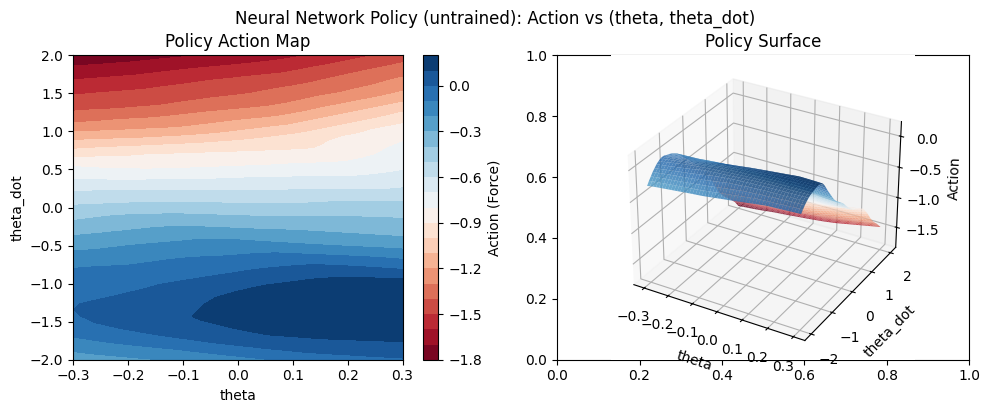

In [12]:
# Visualize the neural network policy surface
fig = plot_policy_surface(
    nn_policy,
    state_ranges={'theta': (-0.3, 0.3), 'theta_dot': (-2, 2)},
    fixed_states={'x': 0, 'x_dot': 0}
)
plt.suptitle('Neural Network Policy (untrained): Action vs (theta, theta_dot)', y=1.02)
plt.show()

## 5. Comparing Policies

Let's compare all our policies side by side!

In [13]:
# Create all policies
policies = {
    'Random': RandomPolicy(),
    'Linear (manual)': LinearPolicy(weights=np.array([0, 0, 10, 3])),
    'Linear (better)': LinearPolicy(weights=np.array([-0.5, -1, 15, 5])),
    'Neural Net': NeuralNetworkPolicy(hidden_sizes=[32, 32])
}

# Evaluate each
results = {}
n_episodes = 100

print(f"Evaluating policies over {n_episodes} episodes...\n")

for name, policy in policies.items():
    result = evaluate_policy(env, policy, n_episodes=n_episodes, seed=42)
    results[name] = result
    print(f"{name:20s}: {result['mean_reward']:6.1f} ± {result['std_reward']:5.1f}")

Evaluating policies over 100 episodes...

Random              :   24.6 ±  11.7


Linear (manual)     :  223.0 ±  92.6


Linear (better)     :  153.3 ±  48.3


Neural Net          :   29.3 ±   8.3


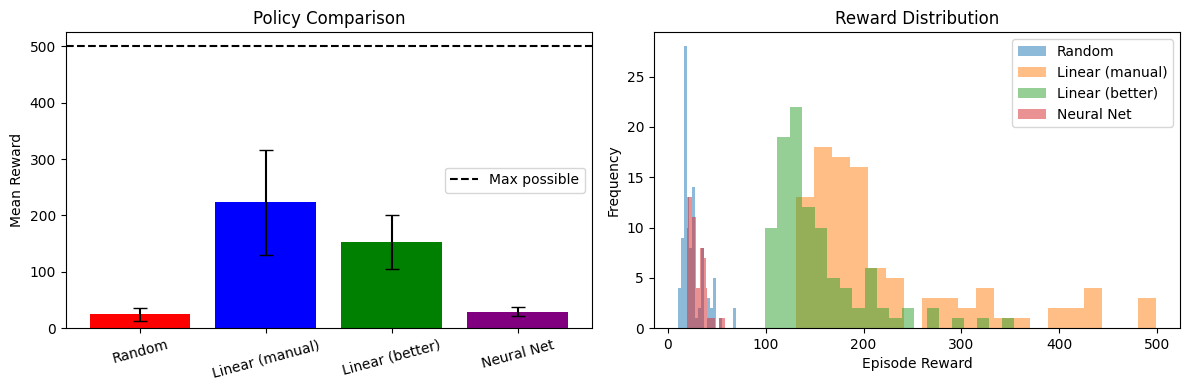

In [14]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

names = list(results.keys())
means = [results[n]['mean_reward'] for n in names]
stds = [results[n]['std_reward'] for n in names]
lengths = [results[n]['mean_length'] for n in names]

# Bar plot of mean rewards
x = range(len(names))
axes[0].bar(x, means, yerr=stds, capsize=5, color=['red', 'blue', 'green', 'purple'])
axes[0].set_xticks(x)
axes[0].set_xticklabels(names, rotation=15)
axes[0].set_ylabel('Mean Reward')
axes[0].set_title('Policy Comparison')
axes[0].axhline(y=env.max_steps, color='k', linestyle='--', label='Max possible')
axes[0].legend()

# Histogram of episode rewards for each policy
for name in names:
    axes[1].hist(results[name]['episode_rewards'], bins=20, alpha=0.5, label=name)
axes[1].set_xlabel('Episode Reward')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reward Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Understanding Policy Parameters

Let's explore how changing parameters affects the linear policy's behavior.

Effect of theta weight (with theta_dot=3):

  w_theta= 2:   62.3
  w_theta= 5:   84.1


  w_theta=10:  207.2


  w_theta=15:  472.9


  w_theta=20:  499.0


  w_theta=30:  499.0


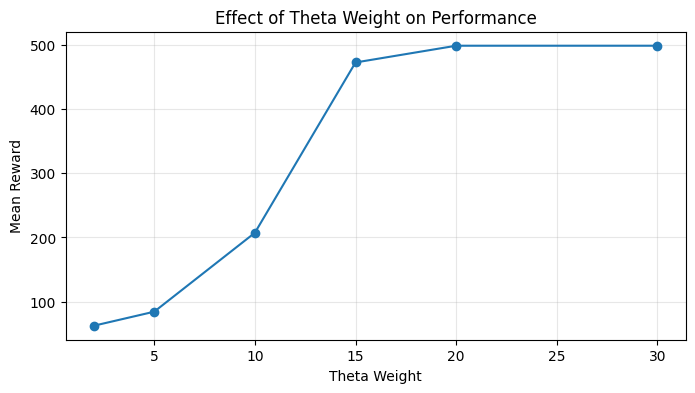

In [15]:
# Experiment with different theta weights
theta_weights = [2, 5, 10, 15, 20, 30]

print("Effect of theta weight (with theta_dot=3):\n")

performances = []
for w_theta in theta_weights:
    policy = LinearPolicy(weights=np.array([0, 0, w_theta, 3]))
    result = evaluate_policy(env, policy, n_episodes=50, seed=42)
    performances.append(result['mean_reward'])
    print(f"  w_theta={w_theta:2d}: {result['mean_reward']:6.1f}")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(theta_weights, performances, 'o-')
plt.xlabel('Theta Weight')
plt.ylabel('Mean Reward')
plt.title('Effect of Theta Weight on Performance')
plt.grid(True, alpha=0.3)
plt.show()

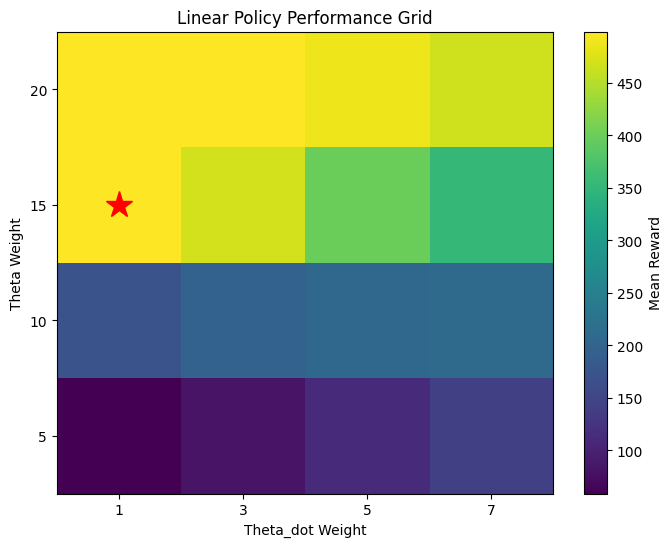

Best weights found: theta=15, theta_dot=1
Performance: 499.0


In [16]:
# Grid search over theta and theta_dot weights
theta_weights = [5, 10, 15, 20]
theta_dot_weights = [1, 3, 5, 7]

performance_grid = np.zeros((len(theta_weights), len(theta_dot_weights)))

for i, w_theta in enumerate(theta_weights):
    for j, w_theta_dot in enumerate(theta_dot_weights):
        policy = LinearPolicy(weights=np.array([0, 0, w_theta, w_theta_dot]))
        result = evaluate_policy(env, policy, n_episodes=30, seed=42)
        performance_grid[i, j] = result['mean_reward']

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(performance_grid, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Mean Reward')
plt.xticks(range(len(theta_dot_weights)), theta_dot_weights)
plt.yticks(range(len(theta_weights)), theta_weights)
plt.xlabel('Theta_dot Weight')
plt.ylabel('Theta Weight')
plt.title('Linear Policy Performance Grid')

# Mark the best
best_idx = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
plt.plot(best_idx[1], best_idx[0], 'r*', markersize=20)
plt.show()

best_theta = theta_weights[best_idx[0]]
best_theta_dot = theta_dot_weights[best_idx[1]]
print(f"Best weights found: theta={best_theta}, theta_dot={best_theta_dot}")
print(f"Performance: {performance_grid.max():.1f}")

## Exercises

### Exercise 1: Better Linear Policy
Can you find a linear policy that achieves the maximum reward (500 steps) consistently?

### Exercise 2: Include Position
Modify the linear policy to also penalize cart position (keep it centered). What weights work?

### Exercise 3: Compare Network Sizes
Create neural networks with different sizes (e.g., [8], [32], [64, 64], [128, 128]). Do larger networks perform better with random weights?

Episode length: 172
Final cart position: -1.47 m


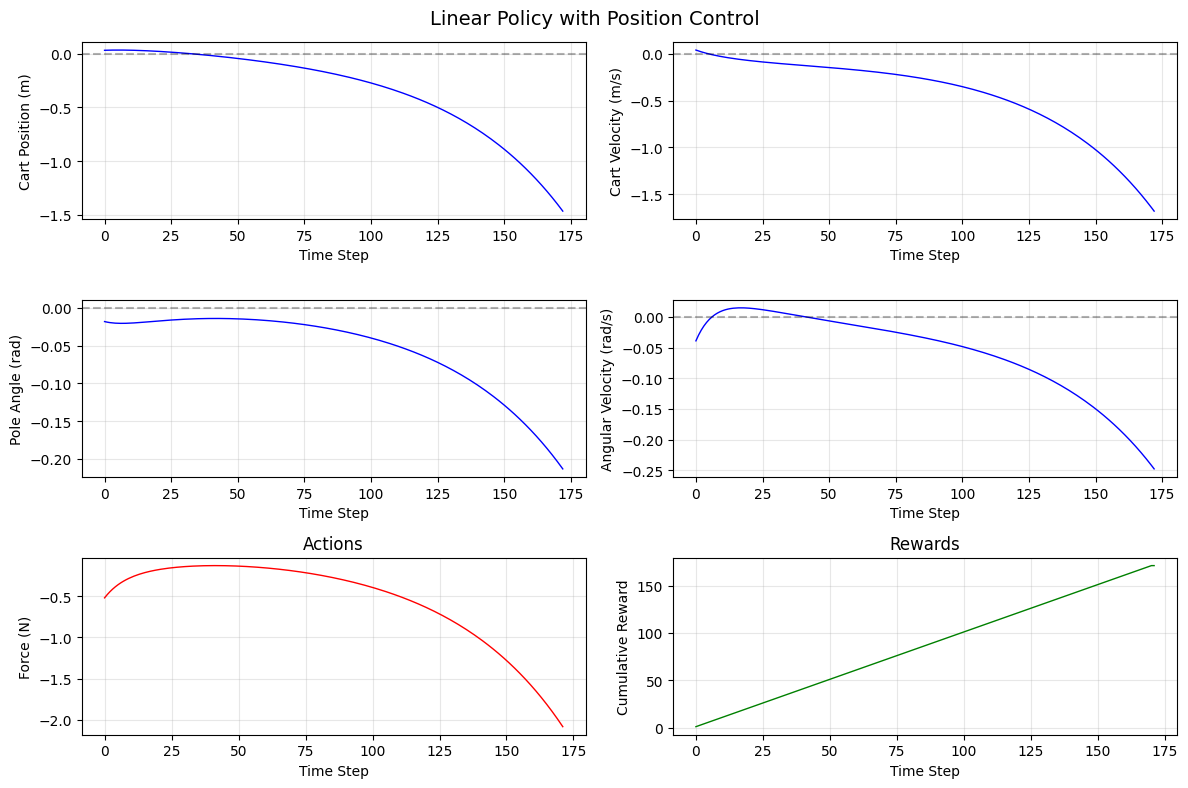

In [17]:
# Exercise 2: Linear policy with position term
# Try to keep the cart centered while balancing

# Weights: [x, x_dot, theta, theta_dot]
# Negative x weight: if cart is to the right (positive x), push left (negative action)

policy_with_position = LinearPolicy(weights=np.array([-1, -0.5, 15, 5]))

# Run an episode
states, actions, rewards, info = collect_episode(env, policy_with_position)

print(f"Episode length: {len(rewards)}")
print(f"Final cart position: {states[-1][0]:.2f} m")

# Plot the trajectory - look at cart position!
history = {
    'states': np.array(states),
    'actions': np.array(actions),
    'rewards': np.array(rewards)
}
fig = plot_trajectory(history, title="Linear Policy with Position Control")
plt.show()

## Summary

In this notebook, we learned:

- **Policies** map states to actions
- **Random policy**: Baseline for comparison
- **Linear policy**: Simple, interpretable, few parameters
- **Neural network policy**: Expressive, many parameters, needs training
- **Parameter choice** significantly affects performance

## Key Insight

The linear policy with manually-chosen weights already works well! This is because the inverted pendulum has relatively simple dynamics.

But what if we don't know the right weights? That's where **learning** comes in!

## Next Steps

In the next notebook, we'll learn how to **train** policies automatically using reinforcement learning algorithms!